In [526]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer

from sklearn.linear_model import LogisticRegression, Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge


In [527]:
hhpub_file_path = 'C:/AdvayRepos/personal_projects/gm_proj/data/hhpub.csv'
vehpub_file_path = 'C:/AdvayRepos/personal_projects/gm_proj/data/vehpub.csv'
perpub_file_path = 'C:/AdvayRepos/personal_projects/gm_proj/data/perpub.csv'

household_data = pd.read_csv(hhpub_file_path)
vehicle_data = pd.read_csv(vehpub_file_path)
personal_data = pd.read_csv(perpub_file_path)

In [528]:
household_data.describe()
#7893 counts


,HOUSEID,WTHHFIN,WTHHFIN5D,WTHHFIN2D,NUMADLT,HOMEOWN,HOMETYPE,RAIL,CENSUS_D,CENSUS_R,...,URBAN,URBANSIZE,URBRUR,PPT517,YOUNGCHILD,RESP_CNT,URBRUR_2010,TDAYDATE,WRKCOUNT,STRATUMID
count,7.893000e+03,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,...,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000,7893.000000
mean,9.000114e+09,16159.217915,16159.217915,16159.217915,1.839351,1.810338,1.566451,1.770936,5.118079,2.641074,...,1.688458,4.181680,1.201064,0.328012,0.104523,2.153427,1.202078,202211.579881,0.996579,1029.458761
std,5.942851e+04,17180.725602,22608.285125,41523.170801,0.753459,0.856616,0.912436,0.420257,2.483650,1.009971,...,1.191865,1.658407,0.400821,0.780185,0.390389,1.132906,0.401575,20.202111,0.902558,4.987184
min,9.000013e+09,103.586134,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,202201.000000,0.000000,1021.000000
25%,9.000057e+09,6384.534030,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,3.000000,2.000000,...,1.000000,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000,202204.000000,0.000000,1025.000000
50%,9.000107e+09,11052.323538,10178.336240,0.000000,2.000000,2.000000,1.000000,2.000000,5.000000,3.000000,...,1.000000,5.000000,1.000000,0.000000,0.000000,2.000000,1.000000,202208.000000,1.000000,1029.000000
75%,9.000166e+09,19498.165382,21556.477769,14757.858351,2.000000,3.000000,2.000000,2.000000,7.000000,3.000000,...,2.000000,6.000000,1.000000,0.000000,0.000000,3.000000,1.000000,202211.000000,2.000000,1033.000000
max,9.000218e+09,308074.698840,468464.128880,746881.674760,8.000000,4.000000,5.000000,2.000000,9.000000,4.000000,...,4.000000,6.000000,2.000000,6.000000,4.000000,10.000000,2.000000,202301.000000,6.000000,1040.000000


In [529]:
#merge relevant tables together
df = pd.merge(vehicle_data, household_data, on='HOUSEID', how='inner')

# Identify duplicate columns
duplicates = [col for col in df.columns if col.endswith(('_x'))]

# Drop the duplicate columns
df = df.drop(columns=duplicates)

# Rename columns with '_y' suffix by removing the suffix
df = df.rename(columns={col: col.replace('_y', '') for col in df.columns})


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14684 entries, 0 to 14683
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HOUSEID           14684 non-null  int64  
 1   VEHID             14684 non-null  int64  
 2   VEHYEAR           14684 non-null  int64  
 3   MAKE              14684 non-null  int64  
 4   VEHTYPE           14684 non-null  int64  
 5   VEHFUEL           14684 non-null  int64  
 6   VEHCOMMERCIAL     14684 non-null  int64  
 7   VEHCOM_RS         14684 non-null  int64  
 8   VEHCOM_DEL        14684 non-null  int64  
 9   VEHCOM_OTH        14684 non-null  int64  
 10  COMMERCIALFREQ    14684 non-null  int64  
 11  HHVEHUSETIME_RS   14684 non-null  int64  
 12  HHVEHUSETIME_DEL  14684 non-null  int64  
 13  HHVEHUSETIME_OTH  14684 non-null  int64  
 14  VEHOWNED          14684 non-null  int64  
 15  WHOMAIN           14684 non-null  int64  
 16  VEHCASEID         14684 non-null  int64 

In [530]:
# Create an OrdinalEncoder instance
year_order = [1982, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
              1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
              2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
              2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
ordinal_encoder = OrdinalEncoder(categories=[year_order])

# Transform the data and add to new column
df['VEHYEAR'] = ordinal_encoder.fit_transform(df[['VEHYEAR']])

df

,HOUSEID,VEHID,VEHYEAR,MAKE,VEHTYPE,VEHFUEL,VEHCOMMERCIAL,VEHCOM_RS,VEHCOM_DEL,VEHCOM_OTH,...,URBAN,URBANSIZE,URBRUR,PPT517,YOUNGCHILD,RESP_CNT,URBRUR_2010,TDAYDATE,WRKCOUNT,STRATUMID
0,9000013002,1,26.0,48,3,1,2,-1,-1,-1,...,1,4,1,2,0,4,1,202202,1,1021
1,9000013002,2,30.0,48,3,1,2,-1,-1,-1,...,1,4,1,2,0,4,1,202202,1,1021
2,9000013016,1,22.0,49,1,1,2,-1,-1,-1,...,1,2,1,0,0,2,1,202202,2,1021
3,9000013039,1,26.0,35,1,1,2,-1,-1,-1,...,1,4,1,2,0,4,1,202201,1,1021
4,9000013041,1,25.0,34,1,1,2,-1,-1,-1,...,1,3,1,0,0,1,1,202201,1,1021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14679,9000218013,1,29.0,30,3,1,2,-1,-1,-1,...,1,1,1,0,0,2,1,202301,0,1031
14680,9000218021,1,27.0,12,3,1,1,2,2,1,...,4,6,2,0,0,1,2,202212,0,1032
14681,9000218034,1,29.0,37,3,1,2,-1,-1,-1,...,4,6,2,0,0,2,2,202212,0,1032
14682,9000218034,2,14.0,49,4,1,2,-1,-1,-1,...,4,6,2,0,0,2,2,202212,0,1032


In [531]:
#MISSING VALUES 

df.isna().sum()
#no null values...but misleading since they have put in different values for data not inputted (-1)

HOUSEID             0
VEHID               0
VEHYEAR             0
MAKE                0
VEHTYPE             0
VEHFUEL             0
VEHCOMMERCIAL       0
VEHCOM_RS           0
VEHCOM_DEL          0
VEHCOM_OTH          0
COMMERCIALFREQ      0
HHVEHUSETIME_RS     0
HHVEHUSETIME_DEL    0
HHVEHUSETIME_OTH    0
VEHOWNED            0
WHOMAIN             0
VEHCASEID           0
ANNMILES            0
HYBRID              0
VEHAGE              0
VEHOWNMO            0
WTHHFIN             0
WTHHFIN5D           0
WTHHFIN2D           0
NUMADLT             0
HOMEOWN             0
HOMETYPE            0
RAIL                0
CENSUS_D            0
CENSUS_R            0
HH_HISP             0
DRVRCNT             0
CNTTDHH             0
CDIVMSAR            0
FLAG100             0
HHFAMINC            0
HHFAMINC_IMP        0
HH_RACE             0
HHSIZE              0
HHVEHCNT            0
HHRELATD            0
LIF_CYC             0
MSACAT              0
MSASIZE             0
TRAVDAY             0
URBAN     

In [532]:
#let's check % not attained for one potential feature
count_1s = (df['HHVEHUSETIME_RS'] == -1).sum()
total = df['HHVEHUSETIME_RS'].notnull().sum()

percent_missing = (count_1s/total)*100
percent_missing
#wow 99% of the data is just missing, probably can drop since -1 in the survey means 'not ascertained'!

99.414328520839

In [533]:
# Count the number of -9 responses for each column
count_neg_1 = (df == -1).sum()

# Count the total number of non-null responses for each column
total_responses = df.notnull().sum()

# Calculate the percentage of -9 responses for each column
percentage_neg_1 = (count_neg_1 / total_responses) * 100

print("Percentage of -1 responses per column:")
print(percentage_neg_1)


Percentage of -1 responses per column:
HOUSEID              0.000000
VEHID                0.000000
VEHYEAR              0.000000
MAKE                 0.000000
VEHTYPE              0.000000
VEHFUEL              0.000000
VEHCOMMERCIAL        0.000000
VEHCOM_RS           90.452193
VEHCOM_DEL          90.452193
VEHCOM_OTH          90.452193
COMMERCIALFREQ      90.452193
HHVEHUSETIME_RS     99.414329
HHVEHUSETIME_DEL    98.644783
HHVEHUSETIME_OTH    92.427132
VEHOWNED             0.000000
WHOMAIN              0.000000
VEHCASEID            0.000000
ANNMILES             0.000000
HYBRID               0.000000
VEHAGE               0.000000
VEHOWNMO            87.946064
WTHHFIN              0.000000
WTHHFIN5D            0.000000
WTHHFIN2D            0.000000
NUMADLT              0.000000
HOMEOWN              0.000000
HOMETYPE             0.000000
RAIL                 0.000000
CENSUS_D             0.000000
CENSUS_R             0.000000
HH_HISP              0.000000
DRVRCNT              0.000000
C

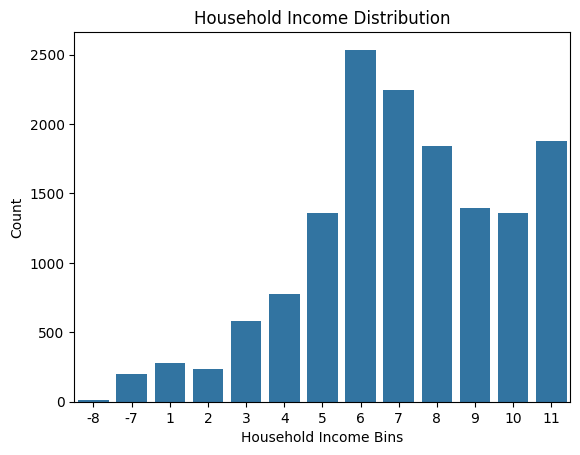

In [534]:
#DATA VIZUALIZATION

sns.countplot(x='HHFAMINC', data=df)
plt.title('Household Income Distribution')
plt.xlabel('Household Income Bins')
plt.ylabel('Count')
plt.show()
#6 is $50,000 to $74,999
#11 is $200k or more
#left skew slight may want normalization

Text(0.45, 1.02, 'Pair Plot of Driver Count, Household Income, and Vehicle Annual Mileage')

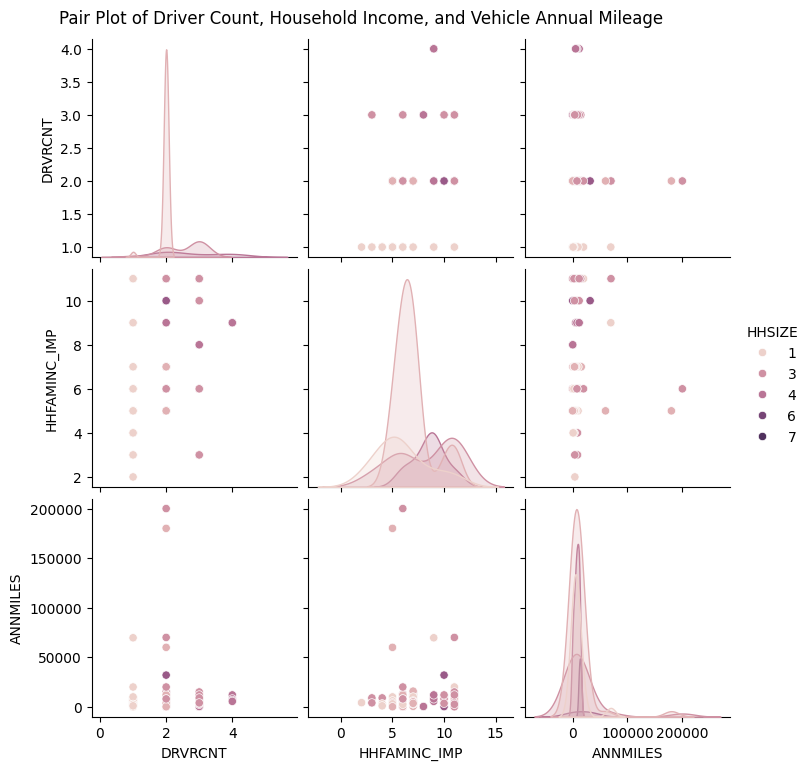

In [535]:
first_df = df[0:100]

prp = sns.pairplot(data = first_df,
             vars = ["DRVRCNT", "HHFAMINC_IMP", "ANNMILES"],  # Data columns used
             kind = "scatter",                      # Kind of plots for different column pairs
             diag_kind = "kde",                     # Diagonal plot kind
             hue = "HHSIZE",                      # Color data by household size
                   )
plt.suptitle("Pair Plot of Driver Count, Household Income, and Vehicle Annual Mileage", x = 0.45, y = 1.02)

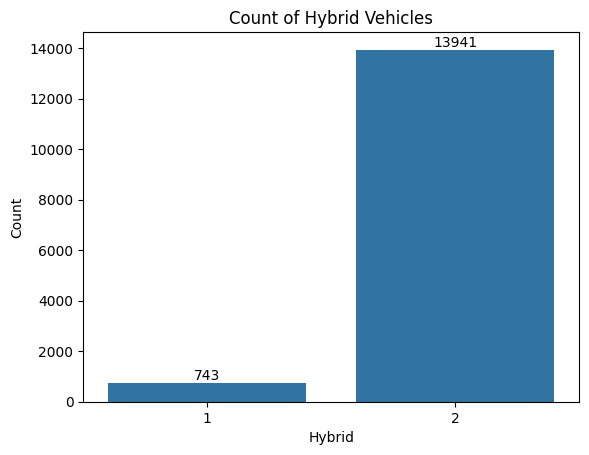

In [536]:
ax = sns.countplot(x='HYBRID', data=df)
plt.title('Count of Hybrid Vehicles')
plt.xlabel('Hybrid')
plt.ylabel('Count')

# Add count labels above the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
#1 is yes so very very skewed, but we're tying to predict the small number in 1!

In [537]:
#let's see how many said yes



(743/(13941+743) )

0.05059929174611823

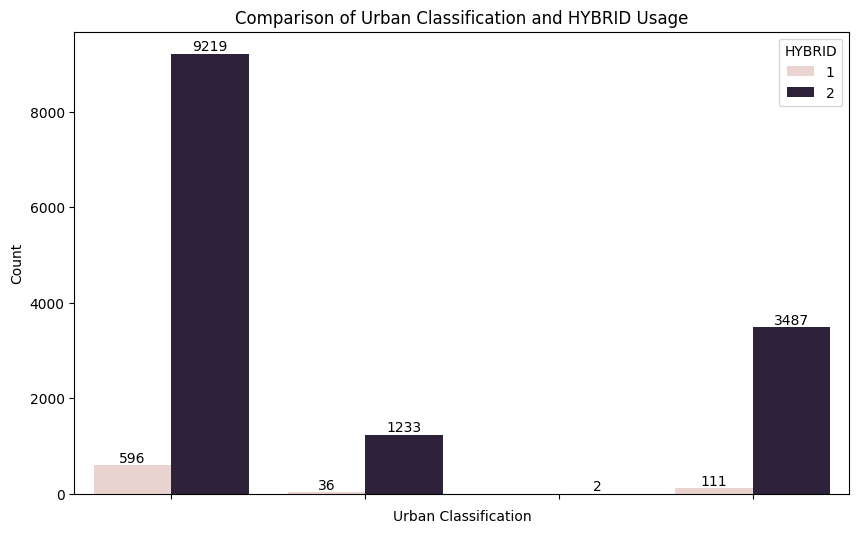

In [538]:



plt.figure(figsize=(10, 6))
ax = sns.countplot(x='URBAN', hue='HYBRID', data=df)
ax.set_title('Comparison of Urban Classification and HYBRID Usage')
ax.set_xlabel('Urban Classification')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(True), rotation=45)
for container in ax.containers:
    ax.bar_label(container)
plt.show()



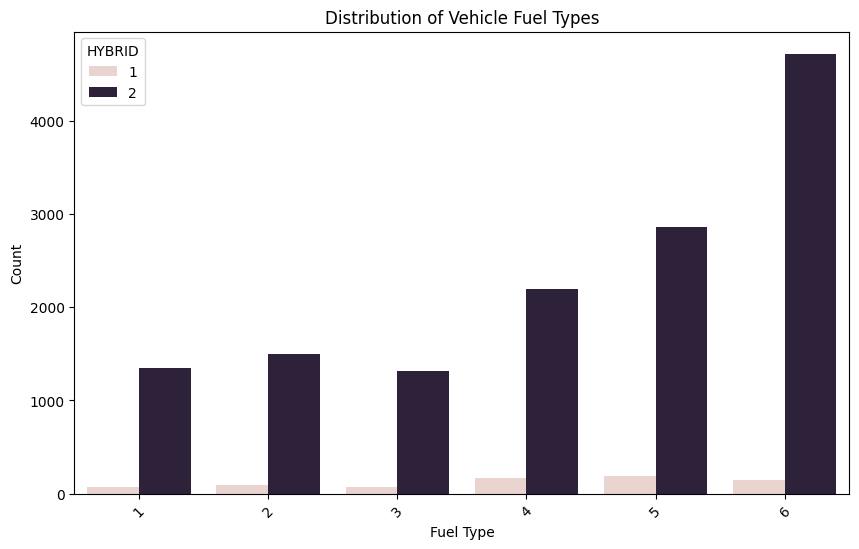

In [539]:


plt.figure(figsize=(10, 6))
sns.countplot(x='URBANSIZE', hue='HYBRID', data=df)
plt.title('Distribution of Vehicle Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


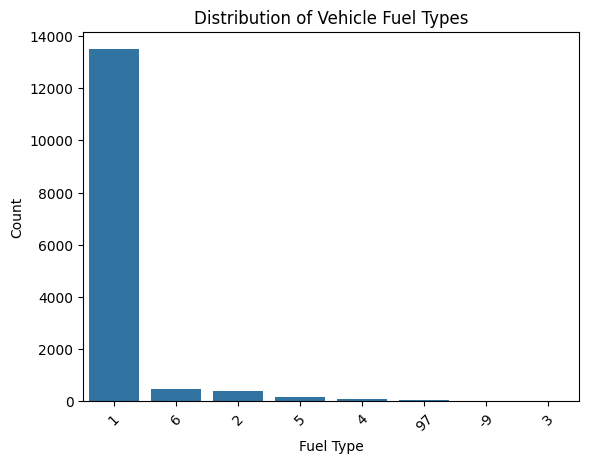

In [540]:


# Count plot for VEHFUEL variable
sns.countplot(x='VEHFUEL', data=df, order=df['VEHFUEL'].value_counts().index)
plt.title('Distribution of Vehicle Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

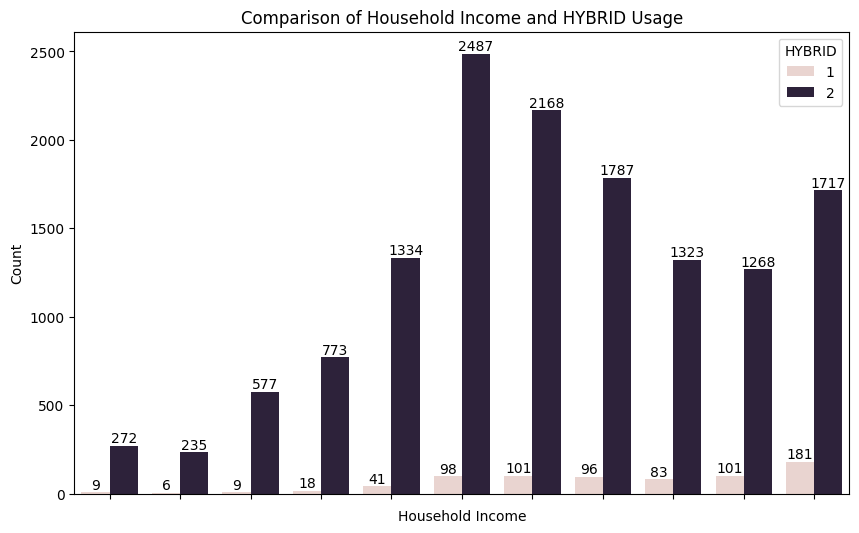

In [541]:


# Count plot for HYBRID by HHFAMINC_IMP
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='HHFAMINC_IMP', hue='HYBRID', data=df)
ax.set_title('Comparison of Household Income and HYBRID Usage')
ax.set_xlabel('Household Income')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(True), rotation=45)

# Add count above each bar using bar_label
for container in ax.containers:
    ax.bar_label(container)

plt.show()


In [542]:
# Filter the DataFrame for rows where HHFAMINC_IMP is 1 and HYBRID is 1
filtered_df = df[(df['HHFAMINC_IMP'] == 1) & (df['HYBRID'] == 1)]

# Count the number of rows in the filtered DataFrame
count_hybrid_and_hhfaminc = len(filtered_df)

# Total number of people with HHFAMINC_IMP = 1
total_hhfaminc_imp_1 = len(df[df['HHFAMINC_IMP'] == 1])

print(f"Number of people with HHFAMINC and HYBRID: {count_hybrid_and_hhfaminc}")
print(f"Total number of people with HHFAMINC_IMP: {total_hhfaminc_imp_1}")


Number of people with HHFAMINC and HYBRID: 9
Total number of people with HHFAMINC_IMP: 281


In [543]:
df['VEHYEAR'].corr(df['VEHAGE'])

-0.9933280550919151

In [544]:
df.dtypes

HOUSEID               int64
VEHID                 int64
VEHYEAR             float64
MAKE                  int64
VEHTYPE               int64
VEHFUEL               int64
VEHCOMMERCIAL         int64
VEHCOM_RS             int64
VEHCOM_DEL            int64
VEHCOM_OTH            int64
COMMERCIALFREQ        int64
HHVEHUSETIME_RS       int64
HHVEHUSETIME_DEL      int64
HHVEHUSETIME_OTH      int64
VEHOWNED              int64
WHOMAIN               int64
VEHCASEID             int64
ANNMILES              int64
HYBRID                int64
VEHAGE                int64
VEHOWNMO              int64
WTHHFIN             float64
WTHHFIN5D           float64
WTHHFIN2D           float64
NUMADLT               int64
HOMEOWN               int64
HOMETYPE              int64
RAIL                  int64
CENSUS_D              int64
CENSUS_R              int64
HH_HISP               int64
DRVRCNT               int64
CNTTDHH               int64
CDIVMSAR              int64
FLAG100               int64
HHFAMINC            

<Axes: xlabel='VEHFUEL', ylabel='ANNMILES'>

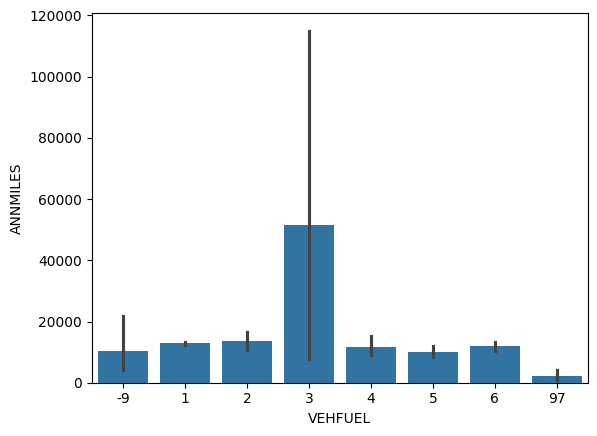

In [545]:
sns.barplot(data = df, x = 'VEHFUEL', y = 'ANNMILES')

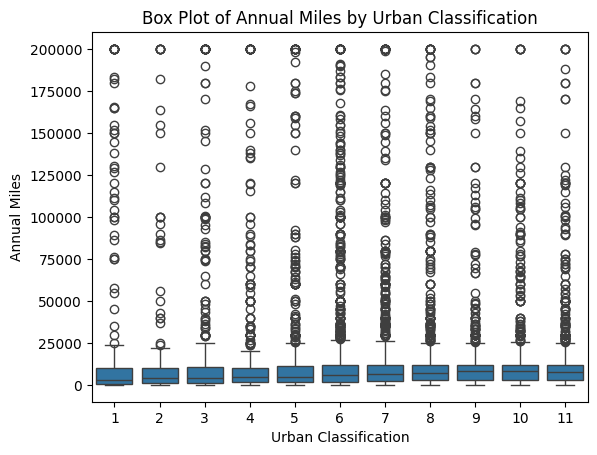

In [546]:
sns.boxplot(data=df, x='HHFAMINC_IMP', y='ANNMILES')
plt.title('Box Plot of Annual Miles by Urban Classification')
plt.xlabel('Urban Classification')
plt.ylabel('Annual Miles')
plt.show()

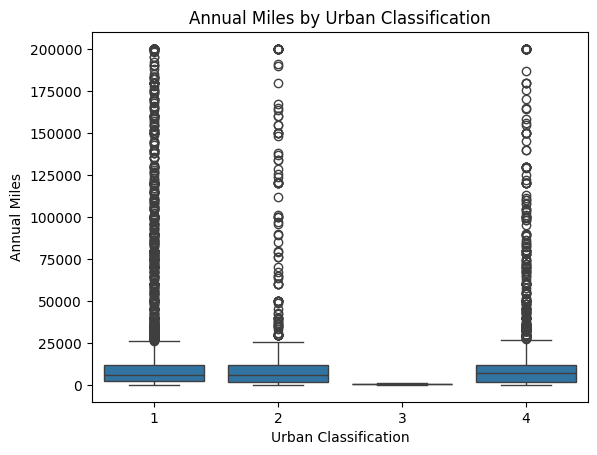

In [547]:
sns.boxplot(x='URBAN', y='ANNMILES', data=df)
plt.title('Annual Miles by Urban Classification')
plt.xlabel('Urban Classification')
plt.ylabel('Annual Miles')
plt.show()

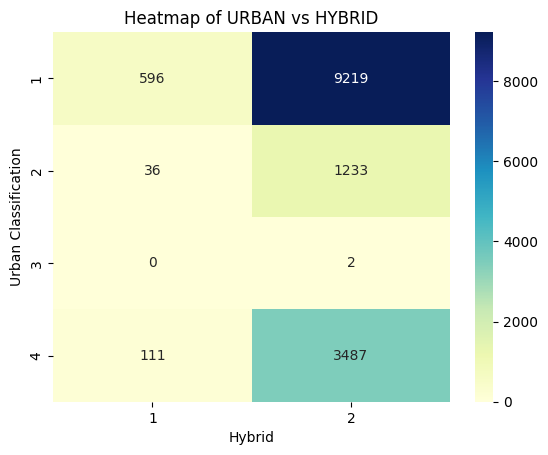

In [548]:
#CORRELATIONS

# Creating a cross-tabulation of URBAN and another categorical variable
cross_tab = pd.crosstab(df['URBAN'], df['HYBRID'])

# Heatmap to visualize the association between URBAN and HYBRID
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Heatmap of URBAN vs HYBRID')
plt.xlabel('Hybrid')
plt.ylabel('Urban Classification')
plt.show()

In [549]:
contingency_table = pd.crosstab(df['URBAN'], df['HYBRID'])

# Perform Chi-Square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f'Chi-Square Statistic: {chi2}')
print(f'P-value: {p}')
print(f'Degrees of Freedom: {dof}')
print(f'Expected Frequencies: \n{ex}')

Chi-Square Statistic: 63.31399641733165
P-value: 1.1506257425441324e-13
Degrees of Freedom: 3
Expected Frequencies: 
[[4.96632048e+02 9.31836795e+03]
 [6.42105012e+01 1.20478950e+03]
 [1.01198583e-01 1.89880142e+00]
 [1.82056252e+02 3.41594375e+03]]


In [550]:
df.columns

Index(['HOUSEID', 'VEHID', 'VEHYEAR', 'MAKE', 'VEHTYPE', 'VEHFUEL',
       'VEHCOMMERCIAL', 'VEHCOM_RS', 'VEHCOM_DEL', 'VEHCOM_OTH',
       'COMMERCIALFREQ', 'HHVEHUSETIME_RS', 'HHVEHUSETIME_DEL',
       'HHVEHUSETIME_OTH', 'VEHOWNED', 'WHOMAIN', 'VEHCASEID', 'ANNMILES',
       'HYBRID', 'VEHAGE', 'VEHOWNMO', 'WTHHFIN', 'WTHHFIN5D', 'WTHHFIN2D',
       'NUMADLT', 'HOMEOWN', 'HOMETYPE', 'RAIL', 'CENSUS_D', 'CENSUS_R',
       'HH_HISP', 'DRVRCNT', 'CNTTDHH', 'CDIVMSAR', 'FLAG100', 'HHFAMINC',
       'HHFAMINC_IMP', 'HH_RACE', 'HHSIZE', 'HHVEHCNT', 'HHRELATD', 'LIF_CYC',
       'MSACAT', 'MSASIZE', 'TRAVDAY', 'URBAN', 'URBANSIZE', 'URBRUR',
       'PPT517', 'YOUNGCHILD', 'RESP_CNT', 'URBRUR_2010', 'TDAYDATE',
       'WRKCOUNT', 'STRATUMID'],
      dtype='object')

In [551]:
#FEATURE ENGINEERING
df['HAS_HYBRID'] = df.groupby('HOUSEID')['HYBRID'].transform(lambda x: 1 if (x == 1).any() else 0)

grouped_df = df.groupby('HOUSEID').first().reset_index()
grouped_df


,HOUSEID,VEHID,VEHYEAR,MAKE,VEHTYPE,VEHFUEL,VEHCOMMERCIAL,VEHCOM_RS,VEHCOM_DEL,VEHCOM_OTH,...,URBANSIZE,URBRUR,PPT517,YOUNGCHILD,RESP_CNT,URBRUR_2010,TDAYDATE,WRKCOUNT,STRATUMID,HAS_HYBRID
0,9000013002,1,26.0,48,3,1,2,-1,-1,-1,...,4,1,2,0,4,1,202202,1,1021,0
1,9000013016,1,22.0,49,1,1,2,-1,-1,-1,...,2,1,0,0,2,1,202202,2,1021,0
2,9000013039,1,26.0,35,1,1,2,-1,-1,-1,...,4,1,2,0,4,1,202201,1,1021,0
3,9000013041,1,25.0,34,1,1,2,-1,-1,-1,...,3,1,0,0,1,1,202201,1,1021,0
4,9000013042,1,28.0,0,3,1,2,-1,-1,-1,...,4,1,0,1,2,1,202202,2,1021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412,9000218006,1,28.0,48,1,1,1,2,2,1,...,3,1,2,0,3,1,202212,1,1031,0
7413,9000218013,1,29.0,30,3,1,2,-1,-1,-1,...,1,1,0,0,2,1,202301,0,1031,0
7414,9000218021,1,27.0,12,3,1,1,2,2,1,...,6,2,0,0,1,2,202212,0,1032,0
7415,9000218034,1,29.0,37,3,1,2,-1,-1,-1,...,6,2,0,0,2,2,202212,0,1032,0


In [552]:
grouped_df["HAS_HYBRID"].value_counts()

HAS_HYBRID
0    6768
1     649
Name: count, dtype: int64

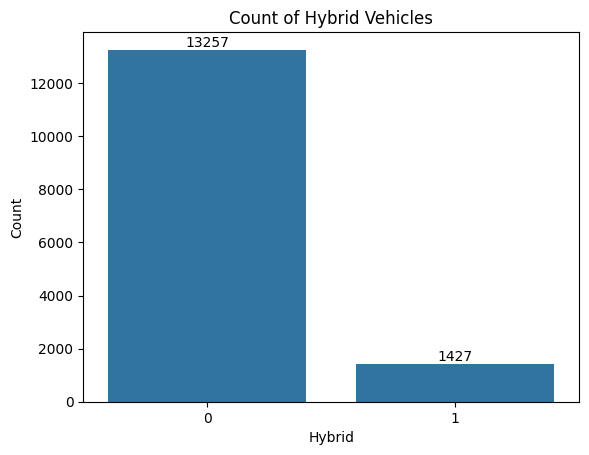

In [553]:
ax = sns.countplot(x='HAS_HYBRID', data=df)
plt.title('Count of Hybrid Vehicles')
plt.xlabel('Hybrid')
plt.ylabel('Count')

# Add count labels above the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
#1 is yes so very very skewed, but we're tying to predict the small number in 1!

In [554]:
#DROPPING BAD FEATURES
df.drop(['VEHCOM_RS', 'VEHCOM_DEL', 'STRATUMID', 'VEHCOM_OTH', 'COMMERCIALFREQ', 'HHVEHUSETIME_RS', 'VEHYEAR', 'HHVEHUSETIME_DEL', 'HHVEHUSETIME_OTH', 'WHOMAIN', 'HHFAMINC'], axis = 1, inplace=True)

In [555]:
#drop IDS because they would only be useful for joining info, will have to remove this if coming back for feature engineering
df.drop(['HOUSEID', 'VEHID', 'VEHCASEID', 'VEHOWNMO'], axis=1, inplace=True)

In [556]:
df.drop(['NUMADLT', 'CENSUS_D', 'HHSIZE'], axis=1, inplace=True)

#NUMADLT
#CENSUS_D
#HHSIZE correlates to RESP_CNT

In [557]:
df.drop(['HYBRID'], axis=1, inplace=True)


<Axes: >

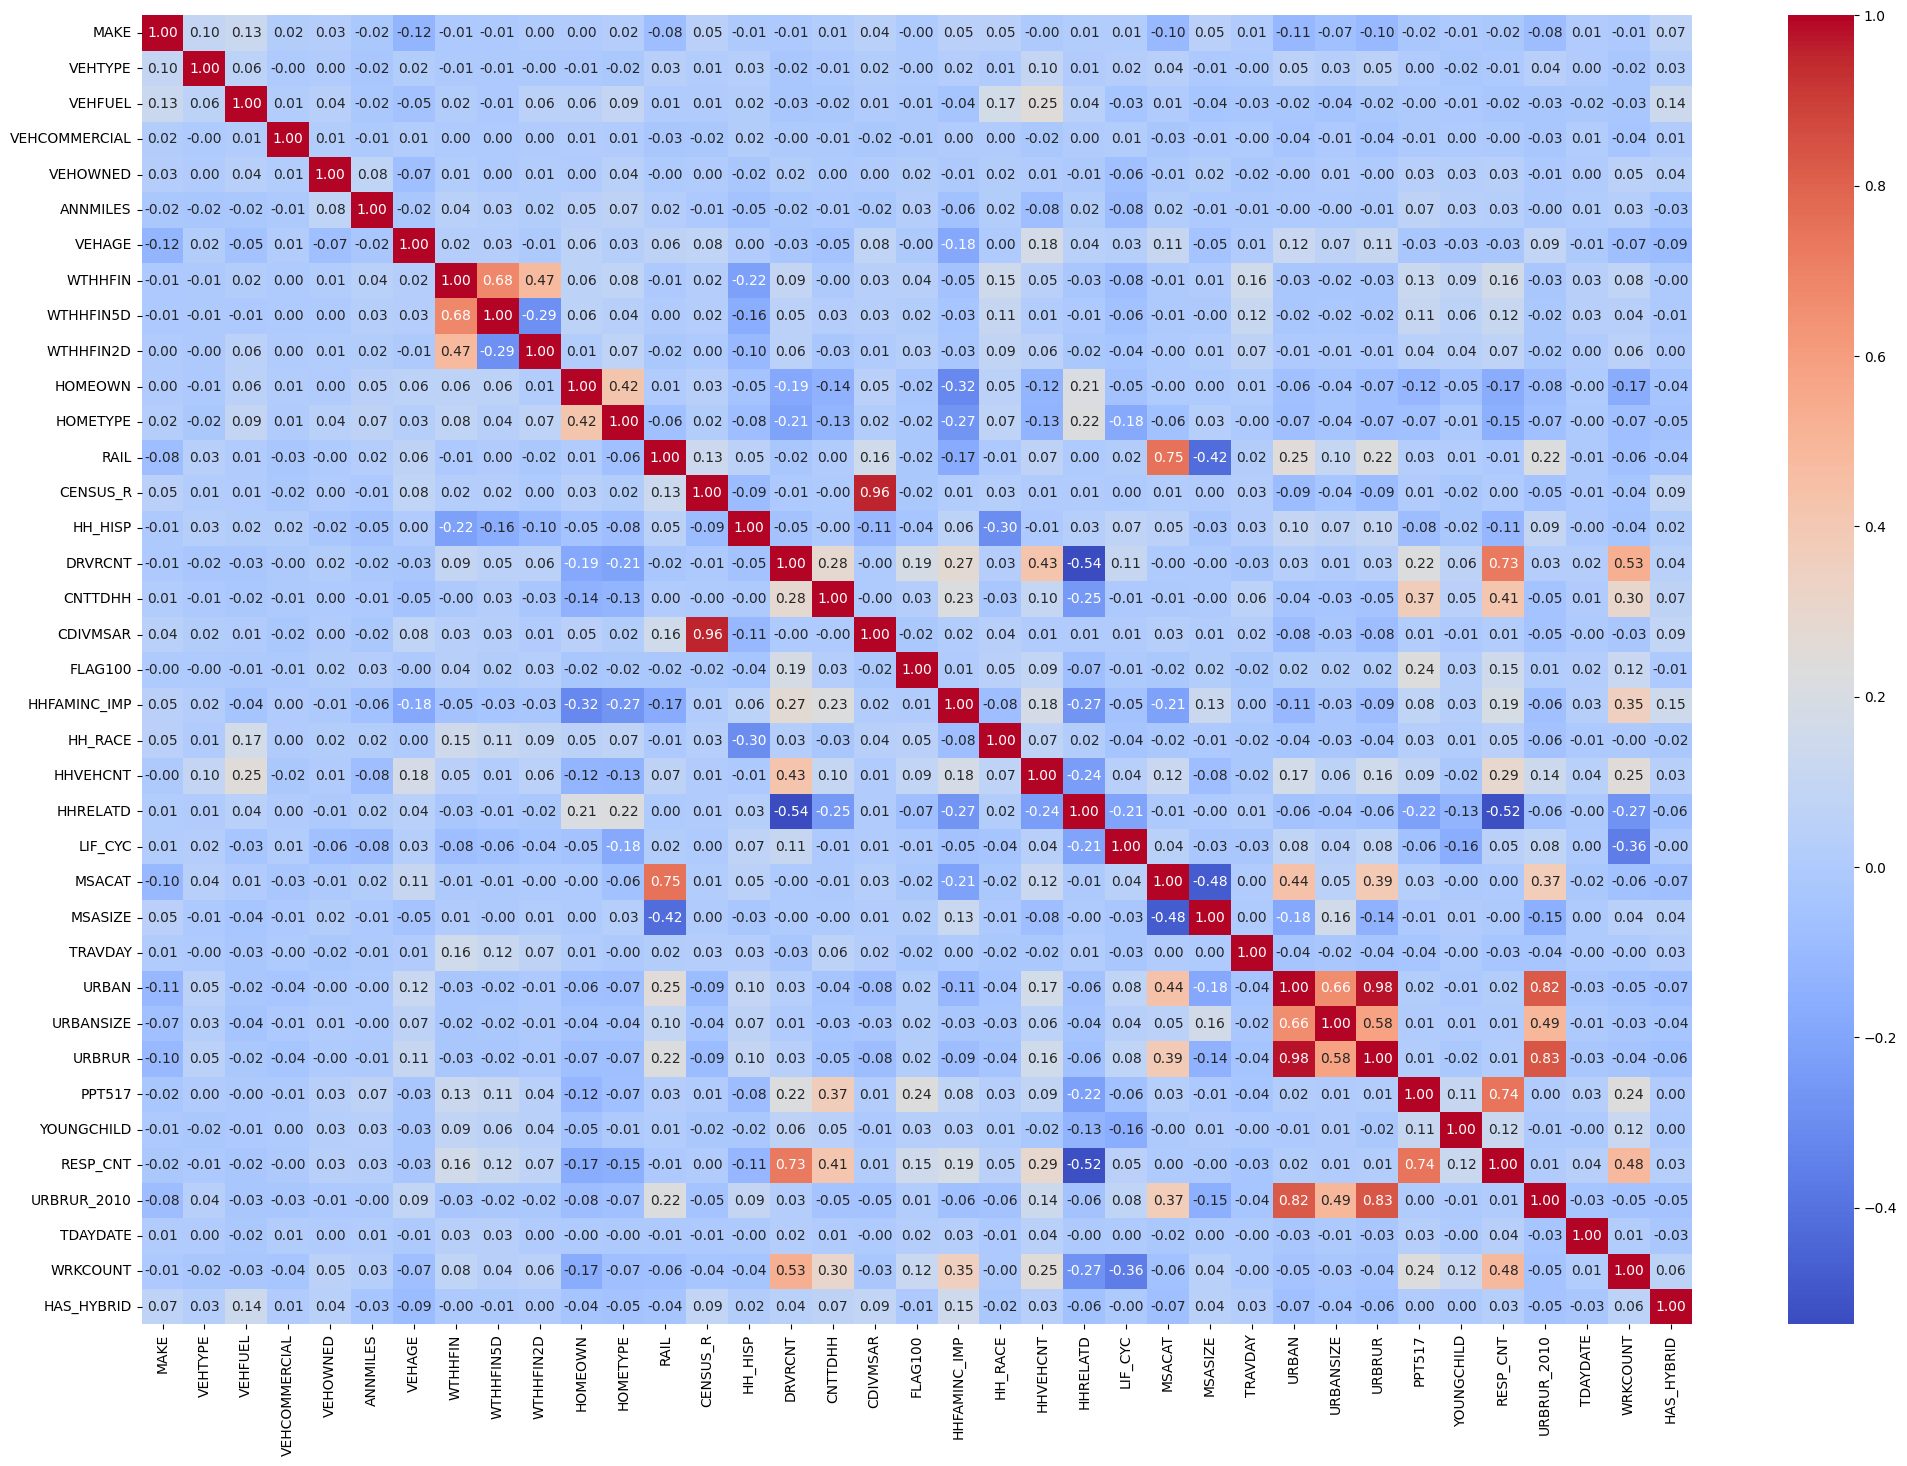

In [558]:
correlation_matrix = df.corr()
plt.figure(figsize = (25, 17))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f")

In [559]:
#MODEL VALIDATION
# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)


In [560]:
df.shape

(14684, 37)

In [561]:
#TRAIN-TEST SPLIT
X = df.drop("HAS_HYBRID", axis=1)
y = df["HAS_HYBRID"]

# This is a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train

4165     0
7791     0
11405    0
9858     0
8991     0
        ..
5191     0
13418    1
5390     0
860      0
7270     0
Name: HAS_HYBRID, Length: 10278, dtype: int64

In [562]:
df.shape

(14684, 37)

In [563]:
#MODEL BUILDING






In [564]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compare to without regularization
logreg_baseline = LogisticRegression(solver='liblinear', random_state=42)
logreg_baseline.fit(X_train_scaled, y_train)
accuracy = logreg_baseline.score(X_test_scaled, y_test)
print(f"Accuracy without regularization: {accuracy:.2f}")

Accuracy without regularization: 0.90


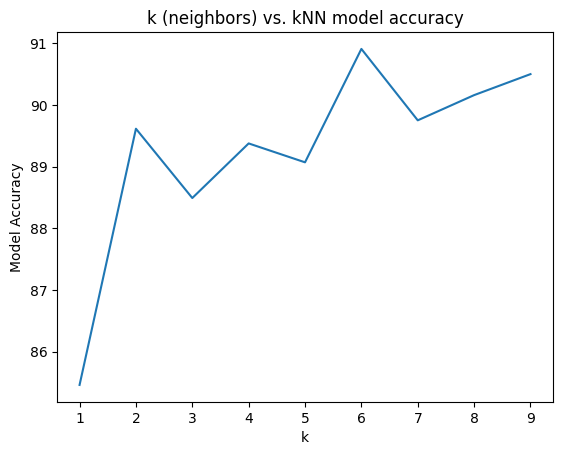

In [565]:
#first tell how many neighbors needed needed
values = []
for i in range(1, 10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    values.append(accuracy*100)
    #print(f"Accuracy: {accuracy * 100:.2f}%")
plt.plot(np.arange(1, 10, 1), values)
plt.title('k (neighbors) vs. kNN model accuracy')
plt.xlabel('k')
plt.ylabel('Model Accuracy')
plt.show()



In [566]:


knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", class_report)

Accuracy: 0.9080694586312564
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      2666
           1       0.52      0.06      0.10       271

    accuracy                           0.91      2937
   macro avg       0.71      0.53      0.53      2937
weighted avg       0.88      0.91      0.87      2937



In [567]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming X_train, X_test, y_train, y_test are already defined

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Print the results
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Classification Report:\n", class_report_rf)


Random Forest Accuracy: 0.9656111678583589
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      2666
           1       0.98      0.64      0.77       271

    accuracy                           0.97      2937
   macro avg       0.97      0.82      0.88      2937
weighted avg       0.97      0.97      0.96      2937



In [573]:
from tensorflow import keras
from tensorflow.keras import layers

# Step 1: Build the neural network model
model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[X_train.shape[1]]), # First hidden layer with 4 neurons
    layers.Dense(4, activation='relu'),                                # Second hidden layer with 4 neurons
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid'),                             # Output layer for binary classification
])
# Step 2: Compile the model with binary cross-entropy loss and accuracy metric
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
# Step 3: Define early stopping callback to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,                    # Number of epochs with no improvement after which training will be stopped
    min_delta=0.0001,                # Minimum change to qualify as an improvement
    restore_best_weights=True,      # Restore model weights from the epoch with the best value of the monitored quantity
)


c:\Users\AdvayAdmin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Axes: title={'center': 'Training and Validation Accuracy'}>

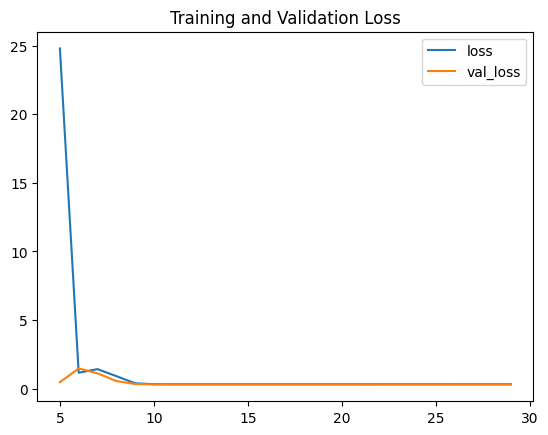

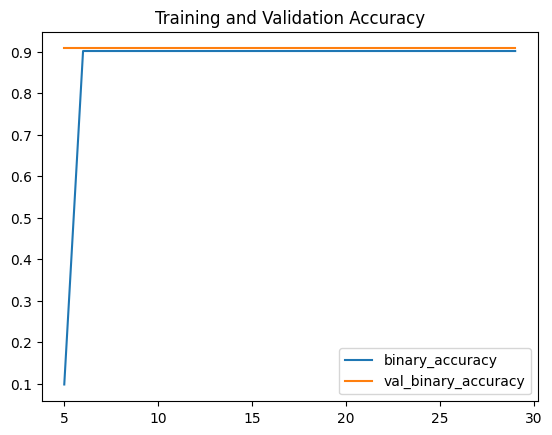

In [574]:
# Step 4: Train the model
history = model.fit(
    X_train, y_train,               # Training data
    validation_data=(X_test, y_test), # Validation data
    batch_size=512,                 # Number of samples per gradient update, used to be 512
    epochs=1000,                    # Number of epochs to train the model
    callbacks=[early_stopping],     # Callback for early stopping
    verbose=0,                      # Hide the output because we have many epochs
)
# Step 5: Visualize training and validation loss and accuracy
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot(title="Training and Validation Loss")
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Training and Validation Accuracy")

In [575]:

# Print the best validation loss and accuracy
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

Best Validation Loss: 0.3075
Best Validation Accuracy: 0.9077
